In [1]:
import torch
import math
import random


In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
# We can update the class Value by

class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f'Value(data = {self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __sub__(self, other):
    return self + (-other)

  def __nul__(self):
    return self * -1

  def __rmul__(self,other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __pow__(self, other):
    if isinstance(other, (int, float)):
      out = Value(self.data ** other, (self, ), f'**{other}')
      def _backward():
        self.grad += other * (self.data ** (other- 1)) * out.grad
      out._backward = _backward
      return out

  def exp(self):
    x = self.data
    t = math.exp(x)
    out = Value(t, (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - (t ** 2)) * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [4]:
# Input x1 and x2
x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True

# Weights w1 and w2 and Bias b
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True

b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True

# sum(x1 * w1) + b
n = x1 * w1 + x2 * w2 + b

# Output function using tanh() activation function
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print(f'x1.grad = {x1.grad}')
print(f'x2.grad = {x2.grad}')
print(f'w1.grad = {w1.grad}')
print(f'w2.grad = {w2.grad}')
print(f'b.grad = {b.grad}')


0.7071066904050358
-----
x1.grad = tensor([-1.5000], dtype=torch.float64)
x2.grad = tensor([0.5000], dtype=torch.float64)
w1.grad = tensor([1.0000], dtype=torch.float64)
w2.grad = tensor([0.], dtype=torch.float64)
b.grad = tensor([0.5000], dtype=torch.float64)


In [5]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

# **(i) Creating Neurons**

In [6]:
class Neuron:
  def __init__(self, nin):
    self.w = [torch.randn(1, requires_grad=True) for _ in range(nin)]
    self.b = torch.randn(1, requires_grad=True)

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)) , self.b)
    out = act.tanh()
    return out


In [7]:
n = Neuron(3)
print(n.w)
print(n.b)
n([2,3,4])

[tensor([-1.5229], requires_grad=True), tensor([-2.7404], requires_grad=True), tensor([-0.3226], requires_grad=True)]
tensor([-0.0609], requires_grad=True)


tensor([-1.], grad_fn=<TanhBackward0>)

# **(ii) Layer**


In [8]:
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
    return outs

In [9]:
x = [2.0, 3.0, -1.0]
l = Layer(3,2)

print(l(x))

[tensor([0.9836], grad_fn=<TanhBackward0>), tensor([0.9821], grad_fn=<TanhBackward0>)]


# **(iii) MLP**

In [10]:
class MLP:
  def __init__(self,nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [11]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4,4,1])

print(m(x))

tensor([-0.9996], grad_fn=<TanhBackward0>)


## **Visualise the above**

In [12]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Value(data = -0.8058614501737532)


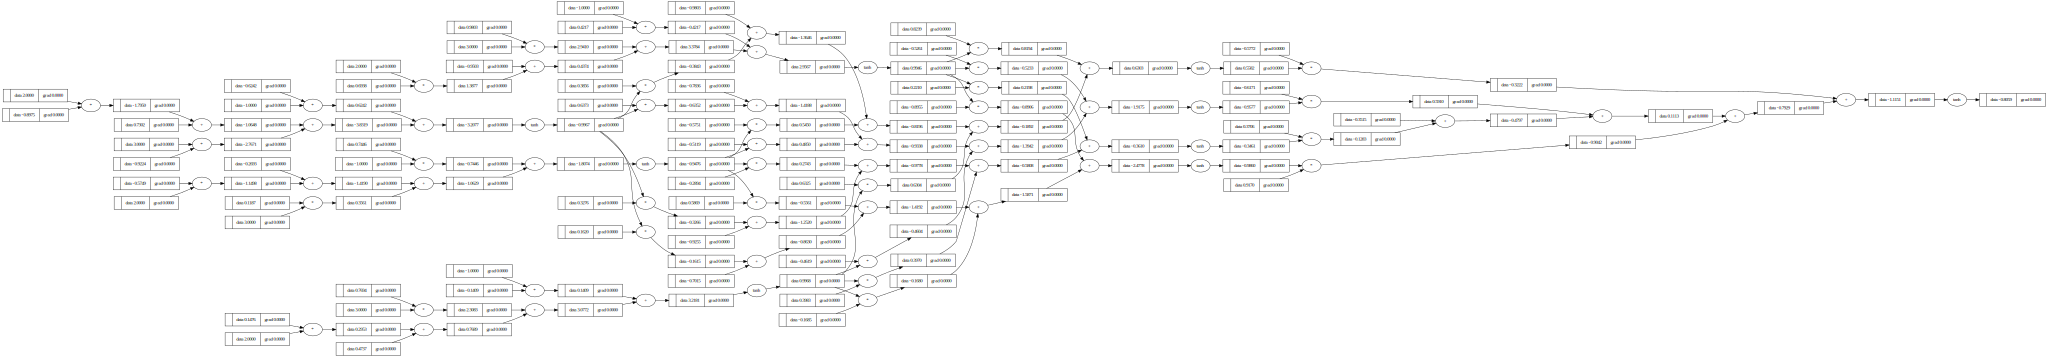

In [13]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4,4,1])

print(m(x))
draw_dot(m(x))

# **Sample Neural network**

In [14]:
m = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [m(x) for x in xs]
ypred

[Value(data = -0.9279835928837572),
 Value(data = 0.5080527566180713),
 Value(data = 0.1744978042640838),
 Value(data = -0.8373649301952586)]

In [15]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss


Value(data = 10.746698830104906)

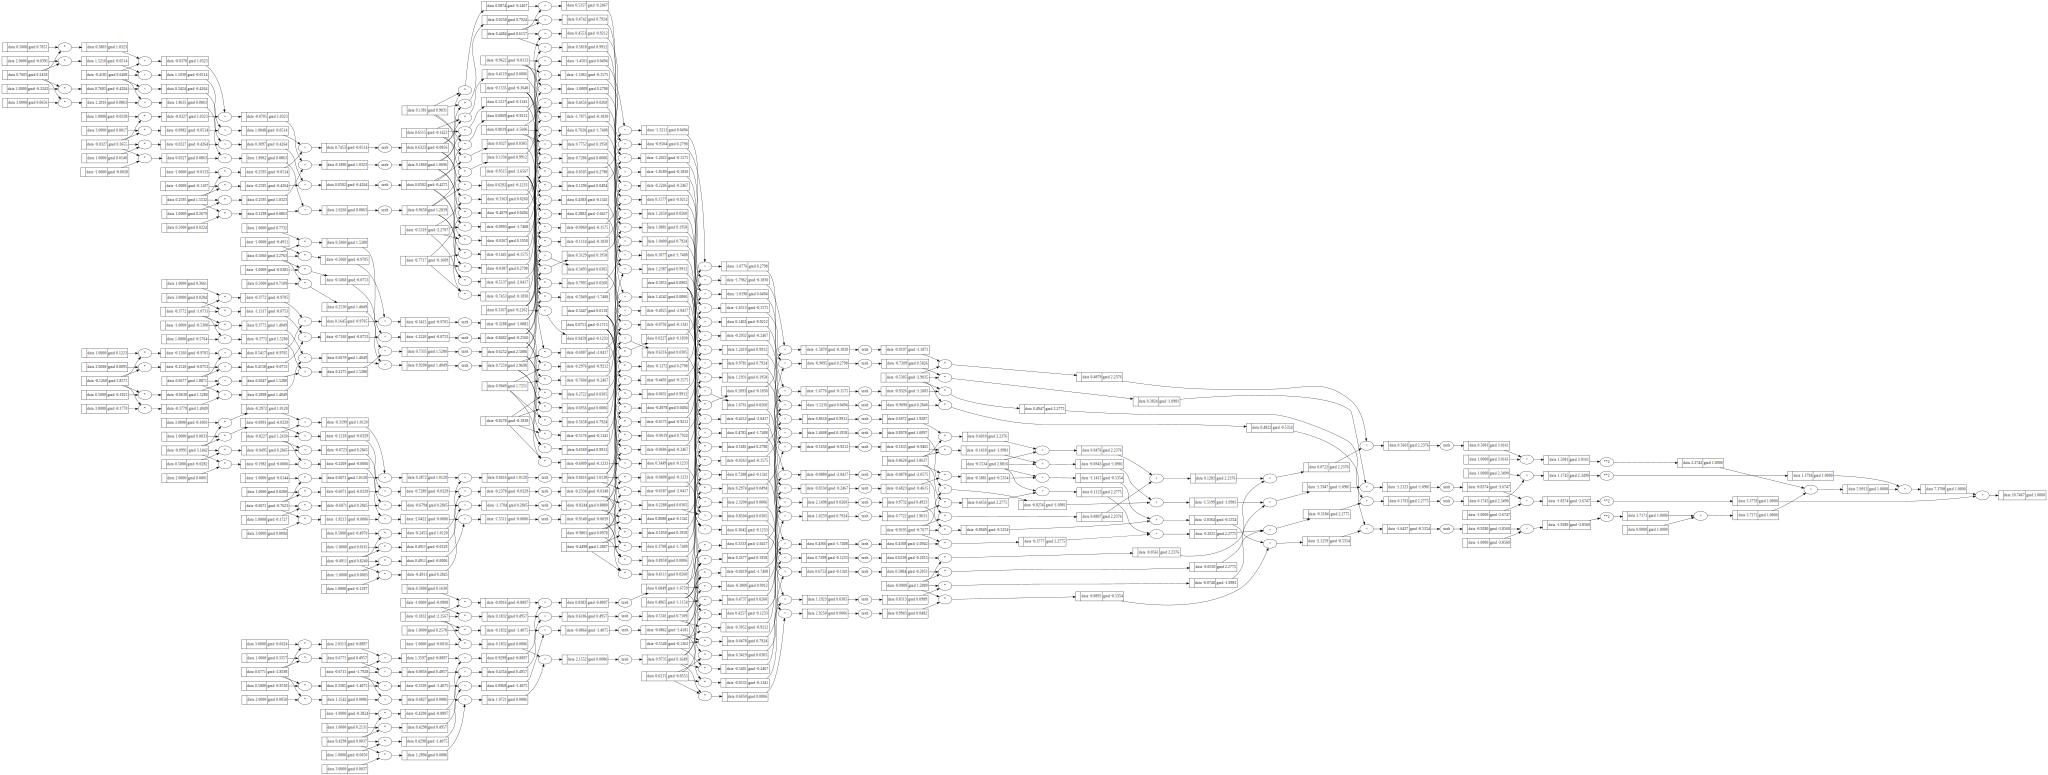

In [16]:
loss.backward()
draw_dot(loss)

In [17]:
m.layers[0].neurons[0].w[0].grad

0.24580784584932674

In [18]:
m.parameters()

[Value(data = 0.7605194740817516),
 Value(data = -0.03272689361536241),
 Value(data = 0.2595160295512895),
 Value(data = -0.41807827065755365),
 Value(data = -0.12597612899694965),
 Value(data = -0.3772423989511535),
 Value(data = 0.5060167587085718),
 Value(data = 0.6677104467898636),
 Value(data = -0.09907532096701588),
 Value(data = -0.6070950031078963),
 Value(data = -0.49105650362953246),
 Value(data = -0.02271758061282214),
 Value(data = 0.6770883845961908),
 Value(data = 0.42980229497938116),
 Value(data = -0.18318918909697413),
 Value(data = -0.67152519552342),
 Value(data = 0.13814811733747967),
 Value(data = 0.9049480418152942),
 Value(data = 0.07507804002128404),
 Value(data = -0.5548419093706454),
 Value(data = 0.4483916463565374),
 Value(data = -0.5319280654664944),
 Value(data = -0.9514914063334468),
 Value(data = -0.4497501386550593),
 Value(data = 0.48654858498090814),
 Value(data = 0.8019096332167923),
 Value(data = 0.6514800232449487),
 Value(data = -0.827841011499468

In [19]:
for p in m.parameters():
  p.data -= 0.001 * p.grad

In [20]:
ypred = [m(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data = 10.616719274742582)

In [21]:
loss.backward()

In [22]:
for epoch in range(50):
  # forward pass
  ypred = [m(x) for x in xs]
  loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in m.parameters():
    p.grad = 0.0
  loss.backward()

  if epoch % 5 == 0:
      print(loss)

  # gradient descend
  for p in m.parameters():
    p.data -= 0.001 * p.grad

Value(data = 10.616719274742582)
Value(data = 9.935634384900194)
Value(data = 9.282095369424615)
Value(data = 8.770996155205996)
Value(data = 8.43099181652961)
Value(data = 8.216676223707102)
Value(data = 8.07808148391036)
Value(data = 7.983242900597768)
Value(data = 7.914274183341871)
Value(data = 7.86123527434828)


In [23]:
ypred

[Value(data = -0.9440660387575325),
 Value(data = -0.6209674875946386),
 Value(data = -0.4419818615909442),
 Value(data = -0.8952305593303767)]